# Fallback Table Metalearning ANALYSIS FOR DELIVERABLE
0. domain level predicitons for all models

Metrics:

1. Agg number of of domains at tld-registrar level. At a day level or month level. Side by side — sum of prob and count of actual

2. Lift @ 10%

3. Inverse of the lift metric . How convincingly we can mark our not-renewal (higher threshold — 30%)

4.  Domain level, confusion matrix. Top ted-reseller combinations . Top 5-7 tld reseller combinations and also at a aggregate level. Determining thresholds — top thresholds go daddy, google, . Compare to (1)


In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")
# install.packages('compare')

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)
library(compare)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')



Attaching package: ‘tidyr’


The following object is masked from ‘package:stringdist’:

    extract




In [5]:
source('functions_metalearning.R')

In [6]:
source('functions_fallback.R')

In [7]:
# source('load_prep_data_expiry_2.R') #read in train test and predictions manually instead

# READ CSV's
# expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")
# expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
# expiry_df_test <- read.csv("../../data/output/datapull_20201116/expiry_df_test.csv")
# metametrics_df <- read.csv("../../data/output/datapull_20201116/expiry_metametrics_df.csv")
# expiry_df
# expiry_train_df 
# expiry_test_df 
# expiry_list
# expiry_train_list
# expiry_test_list

In [8]:
dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116'

modelDir='/home/jupyter/Domains_202003/data/output/models_20201104'

outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'

# Load meta-based predictions on new datapull

In [9]:
# LOAD ORGINAL NEW TEST DATA
expiry_new_df <- readRDS(file.path(outputDir,"expiry_20200902_20201102_20201127"))
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")

expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))
expiry_new_df <- expiry_new_df %>% filter(renewal_type=='FirstTime')
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))


expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

dim(expiry_new_df)
head(expiry_new_df)

Expiry data originally has 430867 rows and 430867 missing geo's.
... after intial merge on reseller & _country, expiry has 430867 rows and 430736 missing geo's.
... after secondary fill with _country, expiry has 430867 rows and 432 missing geo's.
... after manual tweaks with _country, expiry has 430867 rows and 7 missing geo's.


[1] 430867     33

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU


In [10]:
expiry_new_df %>% group_by(renewal_type) %>% tally()

renewal_type,n
<chr>,<int>
FirstTime,430867


In [11]:
expiry_new_df %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1340

In [12]:
# LOAD PREDICTIONS ON NEW TEST DATA
meta_preds <- read.csv(file.path(outputDir, 'meta_preds', 'meta_preds.csv'))

dim(meta_preds)
head(meta_preds)

[1] 491777     37

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,127394801,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,Renewed,0.02477651,preds_agg_rf_ALL
2,2,Alibaba,China,FirstTime,1,2020-09-26,2019-09-26,Active,131294091,hhxx.fun,Alibaba,NA,1,0.75,0.75,0,301715129,renewal,NA,Renewed,2020-03-22,6,0.04,hhxx,1,1261,4,l,4l,fun,China,-0.2876821,funalibaba,China,Renewed,0.02245831,preds_agg_rf_ALL
3,3,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,128437981,songofwar.fun,Alibaba,NA,1,0.75,0.75,0,338293409,renewal,NA,Renewed,2020-08-18,6,5.26,songofwar,1,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,Renewed,0.13746011,preds_agg_rf_ALL
4,4,Alibaba,China,FirstTime,1,2020-09-09,2019-09-09,Active,127774491,loongemperor.fun,Alibaba,NA,1,0.75,0.75,0,317670779,renewal,NA,Renewed,2020-05-26,6,9.03,loongemperor,1,1167,12,l,12l,fun,China,-0.2876821,funalibaba,China,Renewed,0.04351218,preds_agg_rf_ALL
5,5,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,128437976,wantornot.fun,Alibaba,NA,1,0.75,0.75,0,338293424,renewal,NA,Renewed,2020-08-18,6,8.36,waroton,2,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,Renewed,0.07477368,preds_agg_rf_ALL
6,6,Alibaba,China,FirstTime,1,2020-09-05,2019-09-05,Active,126781821,mafengwo.fun,Alibaba,NA,1,0.75,0.75,0,340001059,renewal,NA,Renewed,2020-08-26,6,3.48,mafengwo,1,1276,8,l,8l,fun,China,-0.2876821,funalibaba,China,Renewed,0.05303114,preds_agg_rf_ALL


In [13]:
meta_preds %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1340

In [14]:
# LOAD META-BASED MODEL ASSIGNMENT 
filename <- load(file=file.path(outputDir, 'meta_preds','new_metametrics_imp_pred_df.RData'))
filename
length(new_metametrics_imp_pred_df)
dim(new_metametrics_imp_pred_df)
new_metametrics_assign_df <- new_metametrics_imp_pred_df %>% 
   select(tld_registrar_index,l10_win_04_pred_model,auc_win_04_pred_model) %>% 
   gather(metric, model, c('l10_win_04_pred_model','auc_win_04_pred_model')) %>%
   mutate(metric = str_remove(metric,'_win_04_pred_model')) %>%
   arrange(tld_registrar_index) %>% 
   mutate(model = ifelse(model=='seg2_glm',paste0(model,'_ALL',sep=""),model))
new_metametrics_assign_df %>% select(model) %>% distinct()
new_metametrics_assign_df %>% head(20)

[1] "new_metametrics_imp_pred_df"

[1] 48

[1] 1340   48

model
<chr>
seg2_glm_ALL
agg_rf_ALL
seg2_glm_fb


,tld_registrar_index,metric,model
,<chr>,<chr>,<chr>
1,fun1&1 internet,l10,seg2_glm_ALL
2,fun1&1 internet,auc,seg2_glm_ALL
3,funafrihost,l10,seg2_glm_ALL
4,funafrihost,auc,seg2_glm_ALL
5,funalfahosting,l10,seg2_glm_ALL
6,funalfahosting,auc,seg2_glm_ALL
7,funalibaba,l10,agg_rf_ALL
8,funalibaba,auc,agg_rf_ALL
9,funalibaba sg,l10,seg2_glm_ALL


In [15]:
meta_preds_assign <- left_join(meta_preds %>% mutate(model = str_remove(model,'preds_')),
                             new_metametrics_assign_df,
                             by = c("tld_registrar_index","model"))
dim(meta_preds_assign)
meta_preds_assign %>% distinct((tld_registrar_index)) %>% nrow()
meta_preds_assign %>% select(domain_id, tld_registrar_index, metric, model,actual,predicted) %>% head()

[1] 861734     38

[1] 1340

,domain_id,tld_registrar_index,metric,model,actual,predicted
,<int>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,127394801,funalibaba,l10,agg_rf_ALL,Renewed,0.02477651
2,127394801,funalibaba,auc,agg_rf_ALL,Renewed,0.02477651
3,131294091,funalibaba,l10,agg_rf_ALL,Renewed,0.02245831
4,131294091,funalibaba,auc,agg_rf_ALL,Renewed,0.02245831
5,128437981,funalibaba,l10,agg_rf_ALL,Renewed,0.13746011
6,128437981,funalibaba,auc,agg_rf_ALL,Renewed,0.13746011


In [16]:
meta_preds_assign_l10 <- meta_preds_assign %>% filter(metric=='l10')
dim(meta_preds_assign_l10)
meta_preds_assign_l10 %>% distinct((tld_registrar_index)) %>% nrow()

meta_preds_assign_auc <- meta_preds_assign %>% filter(metric=='auc')
dim(meta_preds_assign_auc)
meta_preds_assign_auc %>% distinct((tld_registrar_index)) %>% nrow()


[1] 430867     38

[1] 1340

[1] 430867     38

[1] 1340

In [17]:
meta_preds_assign_l10 <- meta_preds_assign_l10 %>% rename(pred_l10=predicted, model_l10=model) %>% select(-metric)
meta_preds_assign_auc <- meta_preds_assign_auc %>% rename(pred_auc=predicted, model_auc=model) %>% select(-metric)

meta_preds_assign_all <- inner_join(meta_preds_assign_l10,
                                    meta_preds_assign_auc %>% select('domain_id', 'pred_auc', 'model_auc'),
                                   by = 'domain_id')
dim(meta_preds_assign_all)
names(meta_preds_assign_all)
head(meta_preds_assign_all)

[1] 430867     39

[1] "X"                    "reseller"             "reseller_country"    
 [4] "renewal_type"         "renewed_count"        "expiry_date"         
 [7] "creation_date"        "status"               "domain_id"           
[10] "domain"               "registrar"            "registrant_country"  
[13] "reg_period"           "reg_revenue"          "reg_arpt"            
[16] "renew_mbg"            "renewal_item_id"      "renew_type"          
[19] "autorenew_type"       "renewal_status"       "renew_date"          
[22] "renew_arpt"           "gibb_score"           "pattern"             
[25] "pattern_domain_count" "day_domains"          "sld_length"          
[28] "sld_type"             "sld_type2"            "tld"                 
[31] "region"               "log_reg_arpt"         "tld_registrar_index" 
[34] "reseller_geo"         "actual"               "pred_l10"            
[37] "model_l10"            "pred_auc"             "model_auc"

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,pred_l10,model_l10,pred_auc,model_auc
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<chr>
1,1,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,127394801,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,Renewed,0.02477651,agg_rf_ALL,0.02477651,agg_rf_ALL
2,2,Alibaba,China,FirstTime,1,2020-09-26,2019-09-26,Active,131294091,hhxx.fun,Alibaba,NA,1,0.75,0.75,0,301715129,renewal,NA,Renewed,2020-03-22,6,0.04,hhxx,1,1261,4,l,4l,fun,China,-0.2876821,funalibaba,China,Renewed,0.02245831,agg_rf_ALL,0.02245831,agg_rf_ALL
3,3,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,128437981,songofwar.fun,Alibaba,NA,1,0.75,0.75,0,338293409,renewal,NA,Renewed,2020-08-18,6,5.26,songofwar,1,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,Renewed,0.13746011,agg_rf_ALL,0.13746011,agg_rf_ALL
4,4,Alibaba,China,FirstTime,1,2020-09-09,2019-09-09,Active,127774491,loongemperor.fun,Alibaba,NA,1,0.75,0.75,0,317670779,renewal,NA,Renewed,2020-05-26,6,9.03,loongemperor,1,1167,12,l,12l,fun,China,-0.2876821,funalibaba,China,Renewed,0.04351218,agg_rf_ALL,0.04351218,agg_rf_ALL
5,5,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,128437976,wantornot.fun,Alibaba,NA,1,0.75,0.75,0,338293424,renewal,NA,Renewed,2020-08-18,6,8.36,waroton,2,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,Renewed,0.07477368,agg_rf_ALL,0.07477368,agg_rf_ALL
6,6,Alibaba,China,FirstTime,1,2020-09-05,2019-09-05,Active,126781821,mafengwo.fun,Alibaba,NA,1,0.75,0.75,0,340001059,renewal,NA,Renewed,2020-08-26,6,3.48,mafengwo,1,1276,8,l,8l,fun,China,-0.2876821,funalibaba,China,Renewed,0.05303114,agg_rf_ALL,0.05303114,agg_rf_ALL


# Load all model predictions on new data pull, join with meta preds

In [18]:
fullDir=outputDir
predDir = file.path(fullDir, 'preds')
model_preds = read.csv(file.path(predDir, 'preds.csv'))
model_preds <- model_preds %>% filter(renewal_type=='FirstTime')
dim(model_preds)
model_preds %>% head()

[1] 430867     41

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187


In [19]:
model_preds %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1340

In [20]:
preds_all <- inner_join(meta_preds_assign_all %>% select('domain_id', 'pred_l10','model_l10','pred_auc','model_auc'), 
                        model_preds,
                        by='domain_id')
dim(meta_preds)
dim(model_preds)
dim(preds_all)

[1] 491777     37

[1] 430867     41

[1] 430867     45

# Output for Parag 01/08/2020

In [21]:
head(preds_all)

,domain_id,pred_l10,model_l10,pred_auc,model_auc,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
,<int>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,127394801,0.02477651,agg_rf_ALL,0.02477651,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,0.057,0.02477651,0.051,0.02399424,0.107,0.03376228,0.075906650,0.02512222
2,131294091,0.02245831,agg_rf_ALL,0.02245831,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-26,2019-09-26,Active,hhxx.fun,Alibaba,NA,1,0.75,0.75,0,301715129,renewal,NA,Renewed,2020-03-22,6,0.04,hhxx,1,1261,4,l,4l,fun,China,-0.2876821,funalibaba,China,0.022,0.02245831,0.020,0.02437213,0.044,0.02327520,0.021503494,0.02376224
3,128437981,0.13746011,agg_rf_ALL,0.13746011,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,songofwar.fun,Alibaba,NA,1,0.75,0.75,0,338293409,renewal,NA,Renewed,2020-08-18,6,5.26,songofwar,1,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,0.007,0.13746011,0.007,0.12208318,0.012,0.08330054,0.003070249,0.07448229
4,127774491,0.04351218,agg_rf_ALL,0.04351218,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-09,2019-09-09,Active,loongemperor.fun,Alibaba,NA,1,0.75,0.75,0,317670779,renewal,NA,Renewed,2020-05-26,6,9.03,loongemperor,1,1167,12,l,12l,fun,China,-0.2876821,funalibaba,China,0.023,0.04351218,0.022,0.04256136,0.036,0.05493192,0.014099110,0.04392435
5,128437976,0.07477368,agg_rf_ALL,0.07477368,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-12,2019-09-12,Active,wantornot.fun,Alibaba,NA,1,0.75,0.75,0,338293424,renewal,NA,Renewed,2020-08-18,6,8.36,waroton,2,2379,9,l,9l,fun,China,-0.2876821,funalibaba,China,0.007,0.07477368,0.006,0.06829075,0.012,0.05258968,0.003135144,0.04629859
6,126781821,0.05303114,agg_rf_ALL,0.05303114,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-05,2019-09-05,Active,mafengwo.fun,Alibaba,NA,1,0.75,0.75,0,340001059,renewal,NA,Renewed,2020-08-26,6,3.48,mafengwo,1,1276,8,l,8l,fun,China,-0.2876821,funalibaba,China,0.021,0.05303114,0.019,0.05376797,0.037,0.06301462,0.015506106,0.05744108


In [25]:
cols_long <- preds_all %>% select(contains('pred_')) %>% names()
cols_long

[1] "pred_l10"          "pred_auc"          "pred_agg_glm_ALL" 
 [4] "pred_agg_rf_ALL"   "pred_agg_glm"      "pred_agg_rf"      
 [7] "pred_seg_glm_ALL"  "pred_seg_rf_ALL"   "pred_seg2_glm_ALL"
[10] "pred_seg2_rf_ALL"

In [32]:
preds_all_long <- preds_all %>% 
   pivot_longer(all_of(cols_long), names_to = "model", values_to = "predicted") %>% 
   mutate(model = gsub("pred_l10", "meta_l10", model)) %>% 
   mutate(model = gsub("pred_auc", "meta_auc", model)) %>% 
   mutate(model = gsub("pred_", "", model)) 
head(preds_all_long)

domain_id,model_l10,model_auc,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,model,predicted
<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<dbl>
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,meta_l10,0.02477651
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,meta_auc,0.02477651
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,agg_glm_ALL,0.05700000
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,agg_rf_ALL,0.02477651
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,agg_glm,0.05100000
127394801,agg_rf_ALL,agg_rf_ALL,Alibaba,China,FirstTime,1,2020-09-07,2019-09-07,Active,smzdm.fun,Alibaba,NA,1,0.75,0.75,0,338904759,renewal,NA,Renewed,2020-08-21,6,0.23,smzdm,1,273,5,l,5l,fun,China,-0.2876821,funalibaba,China,agg_rf,0.02399424


In [33]:
dim(preds_all_long)

[1] 4308670      37

In [ ]:
write.csv(preds_all_long ,'../../data/output/deliv_20201218/20200902_20201008_preds_all_long.csv', row.names=FALSE)
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201218/ gs://output_shared/")

# Verify data integrity

In [23]:
preds_all %>%
  select(everything()) %>%  # replace to your needs
  summarise_all(funs(sum(is.na(.)))) %>%
  t()

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


domain_id,0
pred_l10,717
model_l10,0
pred_auc,627
model_auc,0
reseller,0
reseller_country,0
renewal_type,0
renewed_count,0
expiry_date,0
creation_date,0


# Backfill pred_meta with available model preds

In [24]:
# all missing obs ... pertain to seg2_glm
preds_all %>% filter(is.na(pred_l10)) %>% select(model_l10) %>% table()
preds_all %>% filter(is.na(pred_auc)) %>% select(model_auc) %>% table()
# all missing obs ... have agg_rf predictions availale
preds_all %>% filter(is.na(pred_l10)) %>% select(contains('pred')) %>% summarise_all(funs(sum(is.na(.))))
preds_all %>% filter(is.na(pred_auc)) %>% select(contains('pred')) %>% summarise_all(funs(sum(is.na(.))))
# ... so backfill with agg_rf predictions

.
seg2_glm_ALL 
         717 

.
seg2_glm_ALL 
         627 

pred_l10,pred_auc,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
717,623,2,0,345,0,61,14,717,60


pred_l10,pred_auc,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
623,627,2,0,298,0,52,14,627,32


In [25]:
# backfill missing obs from l10 and auc meta-based with agg_rf
preds_all <- preds_all %>% mutate(pred_l10_bf = ifelse(is.na(pred_l10), pred_agg_rf_ALL, pred_l10))
preds_all <- preds_all %>% mutate(pred_auc_bf = ifelse(is.na(pred_auc), pred_agg_rf_ALL, pred_auc))

In [26]:
preds_all %>% filter(is.na(pred_l10)) %>% select(pred_l10, pred_l10_bf, pred_agg_rf_ALL) %>% head()
preds_all %>% filter(is.na(pred_auc)) %>% select(pred_auc, pred_auc_bf, pred_agg_rf_ALL) %>% head()

,pred_l10,pred_l10_bf,pred_agg_rf_ALL
,<dbl>,<dbl>,<dbl>
1,NA,0.5336472,0.5336472
2,NA,0.8064000,0.8064000
3,NA,0.5055587,0.5055587
4,NA,0.1598732,0.1598732
5,NA,0.1678168,0.1678168
6,NA,0.1005532,0.1005532


,pred_auc,pred_auc_bf,pred_agg_rf_ALL
,<dbl>,<dbl>,<dbl>
1,NA,0.2908386,0.2908386
2,NA,0.1431680,0.1431680
3,NA,0.4944094,0.4944094
4,NA,0.4756328,0.4756328
5,NA,0.5336472,0.5336472
6,NA,0.8064000,0.8064000


In [27]:
# for all obs where pred_mate is na, are any pred_meta_bf != pred_agg_rf_ALL NOPE
preds_all %>% filter(is.na(pred_l10)) %>% summarize(sum(pred_l10_bf!=pred_agg_rf_ALL))
preds_all %>% filter(is.na(pred_auc)) %>% summarize(sum(pred_auc_bf!=pred_agg_rf_ALL))

sum(pred_l10_bf != pred_agg_rf_ALL)
<int>
0


sum(pred_auc_bf != pred_agg_rf_ALL)
<int>
0


# Apply fallback to MODEL preds

In [28]:
# read in training data
expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
expiry_df_train_g <- geo_suppl(expiry_df_train, geoLookupDF = geoLookupDF)
# generate list of fallback tables
npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                                 reseller_am_geo_map = geoLookupDF)
names(npv_fallback_list)
for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]])

Expiry data originally has 3729384 rows and 3729384 missing geo's.
... after intial merge on reseller & _country, expiry has 3729384 rows and 3726455 missing geo's.
... after secondary fill with _country, expiry has 3729384 rows and 6983 missing geo's.
... after manual tweaks with _country, expiry has 3729384 rows and 29 missing geo's.


`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'region' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_tld_arpt"     "npv_fallback_second_tld_geo"    
 [5] "npv_fallback_second_geo"         "npv_fallback_third_tld_geo"     
 [7] "npv_fallback_third_geo"          "npv_fallback_first_final"       
 [9] "npv_fallback_second_final"       "npv_fallback_third_final"

In [29]:
# generate list of low-volume tld-re's from training data
tld_registrar_excl_list = tld_registrar_excl_df(expiry_df_train_g)
# generate placeholder columns in preds df for fall backapp
# ... where predictions for low-volume tld-registrars are NA
preds_all <- preds_all %>%
     mutate( across(contains('pred_'), 
                    .fns = list(fb = ~ifelse(tld_registrar_index %in% tld_registrar_excl_list, NA, . )) ))

Excluding 1706 tld-re's (80.89%), due to volume < 500 
Excluding 157 tld-re's (7.44%) associated with tld's 'pw' and 'in.net' 


In [30]:
preds_all %>% select(contains('pred_')) %>% head()

,pred_l10,pred_auc,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_l10_bf,pred_auc_bf,pred_l10_fb,pred_auc_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_l10_bf_fb,pred_auc_bf_fb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.02477651,0.02477651,0.057,0.02477651,0.051,0.02399424,0.107,0.03376228,0.075906650,0.02512222,0.02477651,0.02477651,0.02477651,0.02477651,0.057,0.02477651,0.051,0.02399424,0.107,0.03376228,0.075906650,0.02512222,0.02477651,0.02477651
2,0.02245831,0.02245831,0.022,0.02245831,0.020,0.02437213,0.044,0.02327520,0.021503494,0.02376224,0.02245831,0.02245831,0.02245831,0.02245831,0.022,0.02245831,0.020,0.02437213,0.044,0.02327520,0.021503494,0.02376224,0.02245831,0.02245831
3,0.13746011,0.13746011,0.007,0.13746011,0.007,0.12208318,0.012,0.08330054,0.003070249,0.07448229,0.13746011,0.13746011,0.13746011,0.13746011,0.007,0.13746011,0.007,0.12208318,0.012,0.08330054,0.003070249,0.07448229,0.13746011,0.13746011
4,0.04351218,0.04351218,0.023,0.04351218,0.022,0.04256136,0.036,0.05493192,0.014099110,0.04392435,0.04351218,0.04351218,0.04351218,0.04351218,0.023,0.04351218,0.022,0.04256136,0.036,0.05493192,0.014099110,0.04392435,0.04351218,0.04351218
5,0.07477368,0.07477368,0.007,0.07477368,0.006,0.06829075,0.012,0.05258968,0.003135144,0.04629859,0.07477368,0.07477368,0.07477368,0.07477368,0.007,0.07477368,0.006,0.06829075,0.012,0.05258968,0.003135144,0.04629859,0.07477368,0.07477368
6,0.05303114,0.05303114,0.021,0.05303114,0.019,0.05376797,0.037,0.06301462,0.015506106,0.05744108,0.05303114,0.05303114,0.05303114,0.05303114,0.021,0.05303114,0.019,0.05376797,0.037,0.06301462,0.015506106,0.05744108,0.05303114,0.05303114


In [31]:
# apply fallback tables TST
preds_all <- geo_suppl(preds_all, geoLookupDF = geoLookupDF)
    
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg2_rf_ALL_fb',
               out_col='pred_seg2_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg2_glm_ALL_fb',
               out_col='pred_seg2_glm_ALL_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg_rf_ALL_fb',
               out_col='pred_seg_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg_glm_ALL_fb',
               out_col='pred_seg_glm_ALL_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_rf_fb',
               out_col='pred_agg_rf_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_glm_fb',
               out_col='pred_agg_glm_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_rf_ALL_fb',
               out_col='pred_agg_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_glm_ALL_fb',
               out_col='pred_agg_glm_ALL_fb')

# performance if we backfill all NAs and LOW-VOLUME meta-based NAs with fallback values (no agg_rf used)
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_l10_fb',
               out_col='pred_l10_fb2')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_auc_fb',
               out_col='pred_auc_fb2')

# performance if we backfill meta-based NAs with fallback values (no agg_rf used)
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_l10',
               out_col='pred_l10_fb1')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_auc',
               out_col='pred_auc_fb1')




Expiry data originally has 430867 rows and 430867 missing geo's.
... after intial merge on reseller & _country, expiry has 430867 rows and 7 missing geo's.
... after secondary fill with _country, expiry has 430867 rows and 7 missing geo's.
... after manual tweaks with _country, expiry has 430867 rows and 7 missing geo's.


In [32]:
preds_all %>%
  select(contains('pred')) %>% 
  summarise_all(funs(sum(is.na(.)))) %>% t()

pred_l10,717
pred_auc,627
pred_agg_glm_ALL,2
pred_agg_rf_ALL,0
pred_agg_glm,5593
pred_agg_rf,0
pred_seg_glm_ALL,65
pred_seg_rf_ALL,14
pred_seg2_glm_ALL,743
pred_seg2_rf_ALL,60
pred_l10_bf,0


In [33]:
preds_all %>%
  select(contains('pred')) %>% 
  names()

[1] "pred_l10"             "pred_auc"             "pred_agg_glm_ALL"    
 [4] "pred_agg_rf_ALL"      "pred_agg_glm"         "pred_agg_rf"         
 [7] "pred_seg_glm_ALL"     "pred_seg_rf_ALL"      "pred_seg2_glm_ALL"   
[10] "pred_seg2_rf_ALL"     "pred_l10_bf"          "pred_auc_bf"         
[13] "pred_l10_fb"          "pred_auc_fb"          "pred_agg_glm_ALL_fb" 
[16] "pred_agg_rf_ALL_fb"   "pred_agg_glm_fb"      "pred_agg_rf_fb"      
[19] "pred_seg_glm_ALL_fb"  "pred_seg_rf_ALL_fb"   "pred_seg2_glm_ALL_fb"
[22] "pred_seg2_rf_ALL_fb"  "pred_l10_bf_fb"       "pred_auc_bf_fb"      
[25] "pred_l10_fb2"         "pred_auc_fb2"         "pred_l10_fb1"        
[28] "pred_auc_fb1"

In [34]:
dim(preds_all)
as.data.frame(names(preds_all))
head(preds_all)

[1] 430867     65

names(preds_all)
<fct>
reseller
reseller_country
reseller_geo
domain_id
pred_l10
model_l10
pred_auc
model_auc
renewal_type


,reseller,reseller_country,reseller_geo,domain_id,pred_l10,model_l10,pred_auc,model_auc,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,⋯,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_l10_bf,pred_auc_bf,pred_l10_fb,pred_auc_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_l10_bf_fb,pred_auc_bf_fb,reg_arpt_org,reg_arpt_slab,pred_l10_fb2,pred_auc_fb2,pred_l10_fb1,pred_auc_fb1
,<fct>,<fct>,<fct>,<int>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 Internet,Germany,EU,129547106,0.5921809,agg_rf_ALL,0.5921809,agg_rf_ALL,FirstTime,1,2020-09-17,2019-09-17,Active,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,⋯,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,0.5921809,0.5921809,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,5,"(3,5]",0.5921809,0.5921809,0.5921809,0.5921809
2,1&1 Internet,Germany,EU,76285079,0.6141844,agg_rf_ALL,0.6141844,agg_rf_ALL,FirstTime,1,2020-09-10,2018-09-10,Active,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,⋯,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,0.6141844,0.6141844,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,15,"(10,15]",0.6141844,0.6141844,0.6141844,0.6141844
3,1&1 Internet,Germany,EU,132626216,0.5986996,agg_rf_ALL,0.5986996,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,⋯,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,0.5986996,0.5986996,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,5,"(3,5]",0.5986996,0.5986996,0.5986996,0.5986996
4,1&1 Internet,Germany,EU,127423021,0.4743705,agg_rf_ALL,0.4743705,agg_rf_ALL,FirstTime,1,2020-09-07,2019-09-07,Active,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,⋯,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,0.4743705,0.4743705,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,5,"(3,5]",0.4743705,0.4743705,0.4743705,0.4743705
5,1&1 Internet,Germany,EU,127588571,0.4919164,agg_rf_ALL,0.4919164,agg_rf_ALL,FirstTime,1,2020-09-08,2019-09-08,Active,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,⋯,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,0.4919164,0.4919164,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,5,"(3,5]",0.4919164,0.4919164,0.4919164,0.4919164
6,1&1 Internet,Germany,EU,132629291,0.6497964,agg_rf_ALL,0.6497964,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,⋯,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,0.6497964,0.6497964,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,5,"(3,5]",0.6497964,0.6497964,0.6497964,0.6497964


# Output predictions

In [35]:
write.csv(preds_all %>% select(-c(pred_l10_fb, pred_auc_fb, pred_l10_bf_fb, pred_auc_bf_fb)), 
          '../../data/output/deliv_20201218/20200902_20201008_preds_all.csv', row.names=FALSE)
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201218/ gs://output_shared/")

# Radix metric:
## aggregate probabilities at the tld-reseller level... over day or month
Agg number of of domains at tld-registrar level. At a day level or month level. Side by side — sum of prob and count of actual

In [37]:
# preds_all <- read.csv('../../data/output/deliv_20201218/20200902_20201008_preds_all.csv')

In [36]:
dim(preds_all)
head(preds_all)

[1] 430867     65

,reseller,reseller_country,reseller_geo,domain_id,pred_l10,model_l10,pred_auc,model_auc,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,⋯,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_l10_bf,pred_auc_bf,pred_l10_fb,pred_auc_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_l10_bf_fb,pred_auc_bf_fb,reg_arpt_org,reg_arpt_slab,pred_l10_fb2,pred_auc_fb2,pred_l10_fb1,pred_auc_fb1
,<fct>,<fct>,<fct>,<int>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 Internet,Germany,EU,129547106,0.5921809,agg_rf_ALL,0.5921809,agg_rf_ALL,FirstTime,1,2020-09-17,2019-09-17,Active,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,⋯,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,0.5921809,0.5921809,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,5,"(3,5]",0.5921809,0.5921809,0.5921809,0.5921809
2,1&1 Internet,Germany,EU,76285079,0.6141844,agg_rf_ALL,0.6141844,agg_rf_ALL,FirstTime,1,2020-09-10,2018-09-10,Active,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,⋯,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,0.6141844,0.6141844,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,15,"(10,15]",0.6141844,0.6141844,0.6141844,0.6141844
3,1&1 Internet,Germany,EU,132626216,0.5986996,agg_rf_ALL,0.5986996,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,⋯,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,0.5986996,0.5986996,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,5,"(3,5]",0.5986996,0.5986996,0.5986996,0.5986996
4,1&1 Internet,Germany,EU,127423021,0.4743705,agg_rf_ALL,0.4743705,agg_rf_ALL,FirstTime,1,2020-09-07,2019-09-07,Active,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,⋯,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,0.4743705,0.4743705,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,5,"(3,5]",0.4743705,0.4743705,0.4743705,0.4743705
5,1&1 Internet,Germany,EU,127588571,0.4919164,agg_rf_ALL,0.4919164,agg_rf_ALL,FirstTime,1,2020-09-08,2019-09-08,Active,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,⋯,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,0.4919164,0.4919164,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,5,"(3,5]",0.4919164,0.4919164,0.4919164,0.4919164
6,1&1 Internet,Germany,EU,132629291,0.6497964,agg_rf_ALL,0.6497964,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,⋯,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,0.6497964,0.6497964,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,5,"(3,5]",0.6497964,0.6497964,0.6497964,0.6497964


In [37]:
preds_all$expiry_date <- as.Date(preds_all$expiry_date)
str(preds_all$expiry_date)
head(preds_all)

 Date[1:430867], format: "2020-09-17" "2020-09-10" "2020-10-02" "2020-09-07" "2020-09-08" ...


,reseller,reseller_country,reseller_geo,domain_id,pred_l10,model_l10,pred_auc,model_auc,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,⋯,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_l10_bf,pred_auc_bf,pred_l10_fb,pred_auc_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_l10_bf_fb,pred_auc_bf_fb,reg_arpt_org,reg_arpt_slab,pred_l10_fb2,pred_auc_fb2,pred_l10_fb1,pred_auc_fb1
,<fct>,<fct>,<fct>,<int>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 Internet,Germany,EU,129547106,0.5921809,agg_rf_ALL,0.5921809,agg_rf_ALL,FirstTime,1,2020-09-17,2019-09-17,Active,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,⋯,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,0.5921809,0.5921809,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,5,"(3,5]",0.5921809,0.5921809,0.5921809,0.5921809
2,1&1 Internet,Germany,EU,76285079,0.6141844,agg_rf_ALL,0.6141844,agg_rf_ALL,FirstTime,1,2020-09-10,2018-09-10,Active,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,⋯,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,0.6141844,0.6141844,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,15,"(10,15]",0.6141844,0.6141844,0.6141844,0.6141844
3,1&1 Internet,Germany,EU,132626216,0.5986996,agg_rf_ALL,0.5986996,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,⋯,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,0.5986996,0.5986996,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,5,"(3,5]",0.5986996,0.5986996,0.5986996,0.5986996
4,1&1 Internet,Germany,EU,127423021,0.4743705,agg_rf_ALL,0.4743705,agg_rf_ALL,FirstTime,1,2020-09-07,2019-09-07,Active,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,⋯,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,0.4743705,0.4743705,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,5,"(3,5]",0.4743705,0.4743705,0.4743705,0.4743705
5,1&1 Internet,Germany,EU,127588571,0.4919164,agg_rf_ALL,0.4919164,agg_rf_ALL,FirstTime,1,2020-09-08,2019-09-08,Active,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,⋯,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,0.4919164,0.4919164,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,5,"(3,5]",0.4919164,0.4919164,0.4919164,0.4919164
6,1&1 Internet,Germany,EU,132629291,0.6497964,agg_rf_ALL,0.6497964,agg_rf_ALL,FirstTime,1,2020-10-02,2019-10-02,Active,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,⋯,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,0.6497964,0.6497964,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,5,"(3,5]",0.6497964,0.6497964,0.6497964,0.6497964


In [38]:
options(scipen=999)
library(lubridate)

agg_prob <- preds_all %>% 
   group_by(tld_registrar_index) %>% 
   summarize(sum_pred_l10_bf = round(sum(pred_l10_bf, na.rm=TRUE),4), 
             sum_pred_auc_bf = round(sum(pred_auc_bf, na.rm=TRUE),4), 
             sum_pred_agg_rf_ALL = round(sum(pred_agg_rf_ALL, na.rm=TRUE),4), 
             sum_pred_seg2_glm_ALL_fb = round(sum(pred_seg2_glm_ALL_fb, na.rm=TRUE),4), 
             sum_actl = sum(renewal_status=='Renewed', na.rm=TRUE), 
             count = length(renewal_status))  %>% 
   arrange(desc(count))

agg_prob_day <- preds_all %>% 
   group_by(tld_registrar_index, expiry_date) %>% 
   summarize(sum_pred_l10_bf = round(sum(pred_l10_bf, na.rm=TRUE),4), 
             sum_pred_auc_bf = round(sum(pred_auc_bf, na.rm=TRUE),4), 
             sum_pred_agg_rf_ALL = round(sum(pred_agg_rf_ALL, na.rm=TRUE),4), 
             sum_pred_seg2_glm_ALL_fb = round(sum(pred_seg2_glm_ALL_fb, na.rm=TRUE),4), 
             sum_actl = sum(renewal_status=='Renewed', na.rm=TRUE), 
             count = length(renewal_status))  %>% 
   arrange(desc(count))

agg_prob_month <- preds_all %>% 
   group_by(tld_registrar_index, month=floor_date(as.Date(expiry_date), "month") ) %>% 
   summarize(sum_pred_l10_bf = round(sum(pred_l10_bf, na.rm=TRUE),4), 
             sum_pred_auc_bf = round(sum(pred_auc_bf, na.rm=TRUE),4), 
             sum_pred_agg_rf_ALL = round(sum(pred_agg_rf_ALL, na.rm=TRUE),4), 
             sum_pred_seg2_glm_ALL_fb = round(sum(pred_seg2_glm_ALL_fb, na.rm=TRUE),4), 
             sum_actl = sum(renewal_status=='Renewed', na.rm=TRUE), 
             count = length(renewal_status))  %>% 
   arrange(desc(count))



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [39]:
write.csv(agg_prob ,'../../data/output/deliv_20201218/20200902_20201008_agg_prob.csv', row.names=FALSE)
write.csv(agg_prob_day ,'../../data/output/deliv_20201218/20200902_20201008_agg_prob_day.csv', row.names=FALSE)
write.csv(agg_prob_month ,'../../data/output/deliv_20201218/20200902_20201008_agg_prob_month.csv', row.names=FALSE)

In [40]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201218/ gs://output_shared/")

### aside: visual of Aggregate probabilities by priority

In [41]:
vis_df <- preds_all
# add reseller priority columns to metalearning predictions
priorityLookup_df <- read.csv("/home/jupyter/Domains_202003/data/data_input/PredictiveModelAnalysis_ResellerPriorityList.csv")
names(priorityLookup_df) <- c("market","reseller","npv2020","priority")
priorityLookup_df$reseller <- tolower(priorityLookup_df$reseller)
vis_df$reseller <- tolower(vis_df$reseller)
vis_df <- merge(vis_df, priorityLookup_df, by="reseller", all.x=TRUE)


In [42]:
agg_prob_prio <- vis_df %>% 
   group_by(priority) %>% 
   summarize(sum_pred_l10_bf = round(sum(pred_l10_bf, na.rm=TRUE),4), 
             sum_pred_auc_bf = round(sum(pred_auc_bf, na.rm=TRUE),4), 
             sum_pred_agg_rf_ALL = round(sum(pred_agg_rf_ALL, na.rm=TRUE),4), 
             sum_pred_seg2_glm_ALL_fb = round(sum(pred_seg2_glm_ALL_fb, na.rm=TRUE),4), 
             sum_actl = sum(renewal_status=='Renewed', na.rm=TRUE), 
             count = length(renewal_status))  %>% 
   arrange(desc(count))
agg_prob_prio

`summarise()` ungrouping output (override with `.groups` argument)



priority,sum_pred_l10_bf,sum_pred_auc_bf,sum_pred_agg_rf_ALL,sum_pred_seg2_glm_ALL_fb,sum_actl,count
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,27486.1368,27740.4800,27587.4308,26396.164,23340,317998
2,6335.6203,6206.7984,6289.1868,6106.593,5536,39684
3,3635.1455,3589.7470,3669.2143,3020.204,3011,38575
4,2456.1624,2445.4203,2658.1945,2074.868,2140,34519
NA,14.6967,18.0375,17.7764,16.596,14,91


# lift metric. by tld-reseller

In [43]:
calc_lift <- function (pred_df,
                       P=0.1,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=='Renewed', na.rm=TRUE)
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = TRUE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed', na.rm=TRUE)
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [44]:
preds_all_tldre_list <- split(preds_all, preds_all$tld_registrar_index)

models <- c('pred_l10_bf', 'pred_auc_bf', 'pred_agg_rf_ALL', 'pred_seg2_glm_ALL_fb' )
lift_tldre_list = list()
for (model in models){
    lift_tldre_list[[model]] <- lapply(preds_all_tldre_list,
                                    calc_lift, 
                                    dep_var = "renewal_status", 
                                    pred_var = model)
}

lift_tldre_df <- rbindlist(lift_tldre_list)
lift_tldre_df <- as.data.frame(t(lift_tldre_df))
names(lift_tldre_df) <- str_replace(models, "pred_", "lift_")
lift_tldre_df$tld_registrar_index <- row.names(lift_tldre_df)
lift_tldre_df <- left_join(lift_tldre_df, 
                           preds_all %>% 
                           group_by(tld_registrar_index) %>% tally(),
                           on='tld_registrar_index') %>% arrange (desc(n))
head(lift_tldre_df)

Joining, by = "tld_registrar_index"



,lift_l10_bf,lift_auc_bf,lift_agg_rf_ALL,lift_seg2_glm_ALL_fb,tld_registrar_index,n
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,7.8354978,7.8354978,7.8354978,6.796537,funalibaba,53104
2,9.5276873,9.5276873,9.5276873,8.485342,sitegmo,33517
3,9.1666667,4.4444444,9.1666667,4.444444,spacealibaba,19358
4,0.9318996,0.9318996,0.9318996,1.433692,sitenamecheap,19072
5,1.2052117,1.2052117,1.2052117,2.052117,sitereg.ru,13108
6,8.7500000,5.4166667,8.7500000,7.916667,websitealibaba,12505


In [45]:
write.csv(lift_tldre_df ,'../../data/output/deliv_20201218/20200902_20201008_lift_tldre.csv', row.names=FALSE)
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201218/ gs://output_shared/")

## inverse of the lift. 
below which probability level can we be sure that these domains be dropped (not renewed) the other end of the lift. from the bottom up. will help formulate retention strategy

In [46]:
str(preds_all$renewal_status)

 Factor w/ 2 levels "Not Renewd","Renewed": 2 2 2 2 2 2 2 2 2 2 ...


In [47]:
calc_ilift <- function (pred_df,
                       P=0.3,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=="Not Renewd")
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = FALSE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == "Not Renewd")
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [48]:
# preds_all_tldre_list <- split(preds_all, preds_all$tld_registrar_index)

models <- c('pred_l10_bf', 'pred_auc_bf', 'pred_agg_rf_ALL', 'pred_seg2_glm_ALL_fb' )
ilift_tldre_list = list()
for (model in models){
    ilift_tldre_list[[model]] <- lapply(preds_all_tldre_list,
                                    calc_ilift, 
                                    dep_var = "renewal_status", 
                                    pred_var = model)
}

ilift_tldre_df <- rbindlist(ilift_tldre_list)
ilift_tldre_df <- as.data.frame(t(ilift_tldre_df))
names(ilift_tldre_df) <- str_replace(models, "pred_", "ilift_")
ilift_tldre_df$tld_registrar_index <- row.names(ilift_tldre_df)
ilift_tldre_df <- left_join(ilift_tldre_df, 
                           preds_all %>% 
                           group_by(tld_registrar_index) %>% tally(),
                           on='tld_registrar_index') %>% arrange (desc(n))
head(ilift_tldre_df)

Joining, by = "tld_registrar_index"



,ilift_l10_bf,ilift_auc_bf,ilift_agg_rf_ALL,ilift_seg2_glm_ALL_fb,tld_registrar_index,n
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,1.003915,1.003915,1.003915,1.0038520,funalibaba,53104
2,1.018651,1.018651,1.018651,1.0177390,sitegmo,33517
3,1.001794,1.000242,1.001794,1.0002415,spacealibaba,19358
4,1.013647,1.013647,1.013647,1.0159879,sitenamecheap,19072
5,1.014764,1.014764,1.014764,1.0132021,sitereg.ru,13108
6,1.002056,1.000454,1.002056,0.9972492,websitealibaba,12505


In [49]:
write.csv(ilift_tldre_df ,'../../data/output/deliv_20201218/20200902_20201008_ilift_tldre.csv', row.names=FALSE)
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201218/ gs://output_shared/")

In [50]:
ilift_tldre_df %>% filter((n>251)&(n<300))

ilift_l10_bf,ilift_auc_bf,ilift_agg_rf_ALL,ilift_seg2_glm_ALL_fb,tld_registrar_index,n
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0.9961686,0.9961686,0.9961686,1.047254,sitedotserve inc,298
1.1711712,1.1711712,1.1711712,1.216216,websitehostgator,289
1.0181818,1.0181818,1.0181818,1.018182,pwwhois,280
1.1064426,1.1624650,1.1624650,1.106443,fungmo,278
1.0050891,1.0050891,1.0178117,1.005089,sitebaidu,272
1.0242086,1.0242086,1.0242086,1.135940,storewix,268
1.0606061,1.0606061,1.0606061,1.015152,spaceregister.it,257
1.0365854,1.0162602,1.0162602,1.036585,storeetsy.com,254
1.0092961,1.0092961,1.0092961,1.009296,sitedomainesia,253


## accuracy metrics -- split by priority... by tld. tld priority 2x2 matrix

In [ ]:
head(vis_df)

In [ ]:
vis_df %>% filter((tld=='site') & (priority==1))

In [ ]:
vis_temp <- vis_df %>% group_by(tld,priority) %>% summarize(sum_pred = round(sum(predicted, na.rm=TRUE),4), 
                                                sum_actl = sum(actual=='Renewed', na.rm=TRUE), 
                                                error_pa = round((sum_pred)/(sum_actl+0.0000001),2),
                                                count = length(actual),
                                               )  %>% 
    arrange(desc(count))
head(vis_temp)
tail(vis_temp)

In [ ]:
wide_vis_temp <- vis_temp %>% select(tld, priority, error_pa) %>% spread(priority, error_pa)
head(wide_vis_temp, 24)

In [ ]:
write.csv(wide_vis_temp ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_errorrate_bytldprio_matrix.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

In [ ]:
str(vis_temp$priority)
vis_temp$priority <- factor(vis_temp$priority, levels=c(1,2,3,4))
str(vis_temp$priority)

In [ ]:
summary(vis_temp$error_pa)
summary(vis_temp$error_pa[vis_temp$error_pa<5])
min(vis_temp$error_pa)
max(vis_temp$error_pa)

In [ ]:

options(repr.plot.width=10, repr.plot.height=10)
ggplot(vis_temp[vis_temp$error_pa<5,] , 
       aes(tld, priority, fill=error_pa)) + geom_raster() +geom_text(aes(label=error_pa), size=5)+ 
  theme(legend.position = "none",
       axis.text=element_text(size=15),
        axis.title=element_text(size=20),
       plot.title = element_text(hjust = 0.5, size=20)) + ggtitle('Error Rate (pred/actual) by TLD x Reseller_Priority, excluding tail')


In [ ]:
ggsave('../../data/output/deliv_20201210/20200902_20201008_errorrate_bytldprio_plot.pdf', width=10, height= 10) 
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")

# Evaluate perfromance

In [51]:

lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=preds_all,
                        dep_var = "renewal_status",
                        pred_var = "pred_l10_bf") 

lift_list[["pred_l10_bf"]] <- fallback_lift
auc_list[["pred_l10_bf"]] <- calc_auc(lift_df=fallback_lift)

models <- c('pred_agg_glm_ALL','pred_agg_rf_ALL','pred_agg_glm','pred_agg_rf',
            'pred_seg_glm_ALL','pred_seg_rf_ALL','pred_seg2_glm_ALL','pred_seg2_rf_ALL',
            
            'pred_l10_bf','pred_auc_bf', # meta-based preds, NA's backfilled with agg_rf values
            
            'pred_agg_glm_ALL_fb','pred_agg_rf_ALL_fb','pred_agg_glm_fb','pred_agg_rf_fb',
            'pred_seg_glm_ALL_fb','pred_seg_rf_ALL_fb','pred_seg2_glm_ALL_fb','pred_seg2_rf_ALL_fb',
            
            'pred_l10_fb1','pred_auc_fb1',  # meta-based preds, NA's backfilled with fallback values
            'pred_l10_fb2','pred_auc_fb2' # meta-based preds, NAs and low-volume backfilled with fallback values
           )


for (model in models){
    model_lift <- chart_lift(pred_df=preds_all,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift


In [52]:
prop.table(table(preds_all$renewal_status))


Not Renewd    Renewed 
0.92099418 0.07900582 

In [53]:
plot_multigains <- function (lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


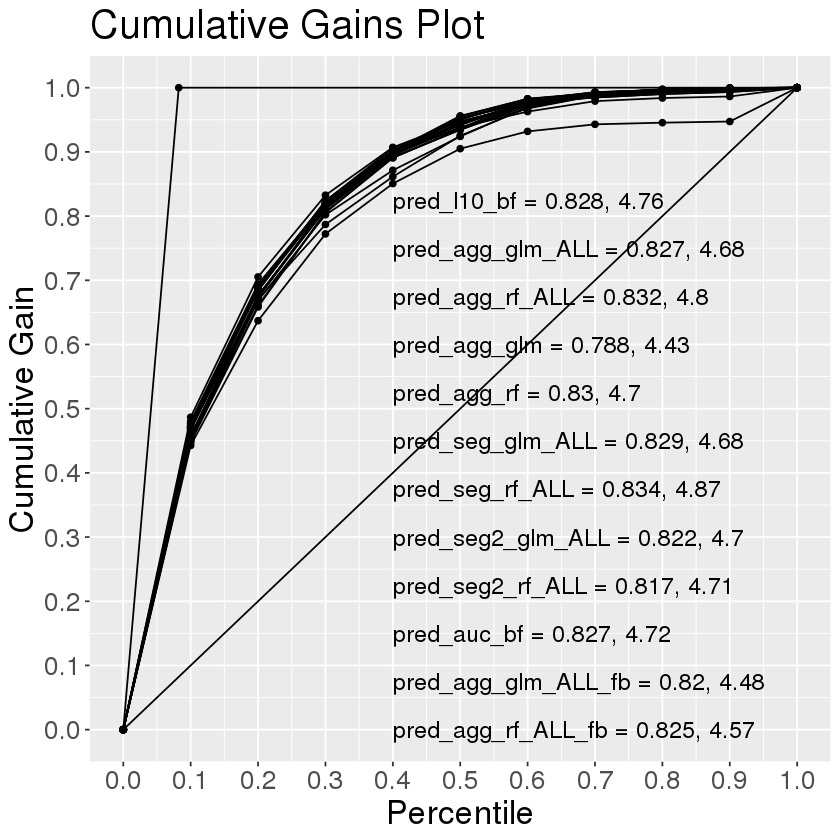

In [54]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.08231877 ) 

In [55]:
lift_df_10 <- lift_df %>% filter(P==0.1) %>% select(contains("lift_")) %>% t
df <- as.data.frame(as.data.frame(lift_df_10))
df %>% arrange(desc(V1))

,V1
,<dbl>
lift_ pred_seg_rf_ALL,4.866778
lift_ pred_agg_rf_ALL,4.798331
lift_ pred_l10_bf,4.763961
lift_ pred_l10_fb1,4.759261
lift_ pred_auc_bf,4.724597
lift_ pred_auc_fb1,4.721365
lift_ pred_seg2_rf_ALL,4.709321
lift_ pred_seg2_glm_ALL,4.704033
lift_ pred_agg_rf,4.697277


In [60]:
# 6% improvement in performance of  agg_rf over backfilled seg2_glm
(lift_df_10['lift_ pred_agg_rf_ALL',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_agg_rf_ALL 
           0.05838139

In [56]:
# 5% improvement in performance of meta based predictions NAs backfilled with agg_rf over backfilled seg2_glm
(lift_df_10['lift_ pred_l10_bf',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]
(lift_df_10['lift_ pred_auc_bf',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_l10_bf 
       0.05080023

lift_ pred_auc_bf 
       0.04211754

In [57]:
# 4% improvement in performance of agg_rf over backfilled seg2_glm
(lift_df_10['lift_ pred_seg2_glm_ALL',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_seg2_glm_ALL 
             0.03758181

In [58]:
(lift_df_10['lift_ pred_l10_bf',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_l10_bf 
       0.05080023

In [59]:
df <- as.data.frame(as.data.frame(as.data.frame(auc_list)) %>% t())
df %>% arrange(desc(V1))

,V1
,<dbl>
pred_seg_rf_ALL,0.8340898
pred_agg_rf_ALL,0.8320481
pred_agg_rf,0.8304882
pred_seg_glm_ALL,0.8291252
pred_seg_rf_ALL_fb,0.8290077
pred_l10_bf,0.8282556
pred_l10_fb1,0.8281234
pred_agg_glm_ALL,0.8272363
pred_auc_bf,0.8268749


In [61]:
# 0.5-0.7% improvement in performance of meta_bf over seg2_glm_fb - auc
auc_list$pred_l10_bf
auc_list$pred_auc_bf
auc_list$pred_seg2_glm_ALL_fb
(auc_list$pred_agg_rf_ALL-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)
(auc_list$pred_l10_bf-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)
(auc_list$pred_auc_bf-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)

[1] 0.8282556

[1] 0.8268749

[1] 0.822821

[1] 0.01121399

[1] 0.006604867

[1] 0.004926873

In [62]:
# 1.1% improvement in performance of agg_rf over seg2_glm_fb - auc
auc_list$pred_agg_rf_ALL
auc_list$pred_seg2_glm_ALL_fb
(auc_list$pred_agg_rf_ALL-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)

[1] 0.8320481

[1] 0.822821

[1] 0.01121399